In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os, time, json, re, copy, gc
import itertools, argparse, pickle, random, math
import os.path as osp

from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import nltk
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn

# import eli5
# from eli5.lime import TextExplainer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, Sampler

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [0]:
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [0]:
SEED = 2019
path = '/content/'

# Seed pytorch
def seed_torch(seed=SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Convert target and identity columns to booleans    
def convert_dataframe_to_bool(df):
    def convert_to_bool(df, col_name):
        df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
    bool_df = df.copy()
    for col in [label_column] + identity_columns + aux_columns:
        convert_to_bool(bool_df, col)
    return bool_df

## Loading data, preprocessing and batchifying

### Download data

In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [0]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification -f train.csv

 98% 268M/273M [00:02<00:00, 108MB/s]
100% 273M/273M [00:02<00:00, 111MB/s]


In [0]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification -f test.csv

 50% 6.00M/12.0M [00:00<00:00, 60.8MB/s]
100% 12.0M/12.0M [00:00<00:00, 76.3MB/s]


In [0]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
!rm train.csv.zip test.csv.zip

### Loading and preprocessing

In [0]:
vocab_size = 100000
max_len = 220

In [0]:
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

aux_columns = ['target', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

label_column = 'target'
pred_column = 'prediction'
text_column = 'comment_text'

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
symbols_to_isolate = ''.join(puncts)
isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}

def clean_punc(x):
    x = str(x)
    x = x.translate(isolate_dict)
    return x

def clean_text(raw):
    return clean_punc(raw.lower()).strip()

In [0]:
def word_idx_map(raw_comments, vocab_size):
    """
    :return: word, index mapping
    """
    def build_vocab(sentences):
        """
        :param sentences: list of list of words
        :return: dictionary of words and their count
        """
        vocab = {}
        for sentence in sentences:
            for word in sentence:
                try:
                    vocab[word] += 1
                except KeyError:
                    vocab[word] = 1
        return vocab

    def most_common_vocab(vocab, k):
        """
        :param vocab: dictionary of words and their count
        :k: former k words to return
        :return: list of k most common words
        """
        sorted_vocab = sorted([(cnt,w) for w,cnt in vocab.items()])[::-1]
        return [(w,cnt) for cnt,w in sorted_vocab][:k]

    texts = [c.split() for c in raw_comments]
    word_freq = build_vocab(texts)
    vocab_freq = most_common_vocab(word_freq, vocab_size)
    idx_to_word = ['<pad>'] + [word for word, cnt in vocab_freq] + ['<unk>']
    word_to_idx = {word:idx for idx, word in enumerate(idx_to_word)}

    return word_to_idx, idx_to_word

def tokenize(comments, word_to_idx, maxlen):
    '''
    Tokenize and numerize the comment sequences
    Inputs:
    - comments: pandas series of comments
    - word_to_idx: word to index mapping
    - maxlen: max length of each sequence of tokens

    Returns:
    - tokens: list of sequences (also list of tokens with length maxlen)
              with length data_size
    '''

    def text_to_id(c, word_to_idx, maxlen):
        return [(lambda x: word_to_idx[x] if x in word_to_idx else word_to_idx['<unk>'])(w) \
                 for w in c.split()[-maxlen:]]

    return np.array([text_to_id(c, word_to_idx, maxlen) for c in comments])

In [0]:
def load_and_preproc():
    train_df = pd.read_csv(path+'train.csv')
    test_df = pd.read_csv(path+'test.csv')
    train_df[identity_columns] = train_df[identity_columns].copy().fillna(0)

    print('cleaning text...')
    t0 = time.time()
    train_df[text_column] = train_df[text_column].apply(clean_text)
    test_df[text_column] = test_df[text_column].apply(clean_text)
    print('cleaning complete in {:.0f} seconds.'.format(time.time()-t0))

    id_cols = train_df[identity_columns].copy().fillna(0).values
    train_tars = train_df[[label_column]+aux_columns].values
    train_tars = np.hstack([train_tars, id_cols]).astype('float32')

    train_df = convert_dataframe_to_bool(train_df)
    df = train_df[[label_column]+identity_columns].copy()
    df[label_column] = df[label_column].astype('uint8')

    return train_df[text_column], train_tars, test_df[text_column], df

In [0]:
%%time
np.random.seed(SEED)
train_seq, train_tars, x_test, trn_df = load_and_preproc()

cleaning text...
cleaning complete in 40 seconds.
CPU times: user 52 s, sys: 1.72 s, total: 53.8 s
Wall time: 53.8 s


In [0]:
%%time
word_to_idx, idx_to_word = word_idx_map(train_seq.tolist()+x_test.tolist(), vocab_size)
del x_test

CPU times: user 59.2 s, sys: 2.69 s, total: 1min 1s
Wall time: 1min 1s


### train/val split

In [0]:
trn_df.shape

(1804874, 10)

In [0]:
def train_val_split(train_x, train_y):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    cv_indices = [(tr_idx, val_idx) for tr_idx, val_idx in kf.split(train_x, train_y)]
    return cv_indices

cv_indices = train_val_split(train_seq, (train_tars[:,0]>=0.5).astype(int))

In [0]:
trn_idx, val_idx = cv_indices[-1]

x_train, x_val = train_seq[trn_idx], train_seq[val_idx]
y_train, y_val = train_tars[trn_idx], train_tars[val_idx]

In [0]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1443900,), (360974,), (1443900, 17), (360974, 17))

In [0]:
trn_df[trn_df['target']==1][:10]

target   male  female  ...  black  white  psychiatric_or_mental_illness
4         1  False   False  ...  False  False                          False
5         1  False   False  ...  False  False                          False
13        1  False   False  ...  False  False                          False
14        1  False   False  ...  False  False                          False
19        1  False   False  ...  False  False                          False
31        1  False   False  ...  False  False                          False
34        1  False    True  ...  False  False                          False
84        1  False   False  ...  False  False                          False
105       1  False   False  ...  False  False                          False
123       1  False   False  ...  False  False                          False

[10 rows x 10 columns]

In [0]:
val_df = trn_df.iloc[val_idx]
val_df[val_df['target']==1][:10]

target   male  female  ...  black  white  psychiatric_or_mental_illness
13        1  False   False  ...  False  False                          False
14        1  False   False  ...  False  False                          False
188       1  False   False  ...  False  False                          False
225       1  False   False  ...  False  False                          False
228       1  False   False  ...  False  False                          False
703       1  False   False  ...  False  False                          False
842       1  False   False  ...  False  False                           True
879       1  False   False  ...  False  False                          False
932       1  False   False  ...  False  False                          False
996       1  False   False  ...  False  False                          False

[10 rows x 10 columns]

In [0]:
del train_seq, train_tars, trn_df

In [0]:
print('tokenizing...')
t0 = time.time()
x_val = tokenize(x_val, word_to_idx, max_len)
print('tokenizing complete in {:.0f} seconds.'.format(time.time()-t0))

tokenizing...
tokenizing complete in 12 seconds.


### data loader

In [0]:
# Prepare dataset and dataloader
class Toxic_comments(Dataset):

    def __init__(self, tokenized_comments, targets=None, split=None, maxlen=256):
        self.comments = tokenized_comments
        self.targets = targets
        self.split = split
        assert self.split in {'train', 'valid', 'test'}
        self.maxlen = maxlen

    def __getitem__(self, index):
        comment = self.comments[index]
        if self.targets is not None:
            target = self.targets[index]
            return comment, torch.FloatTensor(target)
        else:
            return comment

    def __len__(self):
        return len(self.comments)

    def get_lens(self):
        lengths = np.fromiter(
            ((min(self.maxlen, len(seq))) for seq in self.comments),
            dtype=np.int32)
        return lengths

    def collate_fn(self, batch):
        """
        Collate function for sequence bucketing
        Note: this need not be defined in this Class, can be standalone.

        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of comments, and targets
        """

        if self.split in ('train', 'valid'):
            comments, targets = zip(*batch)
        else:
            comments = batch

        lengths = [len(c) for c in comments]
        maxlen = max(lengths)
        padded_comments = []
        for i, c in enumerate(comments):
            padded_comments.append([0]*(maxlen - lengths[i])+c)

        if self.split in ('train', 'valid'):
            return torch.LongTensor(padded_comments), torch.stack(targets)
        else:
            return torch.LongTensor(padded_comments)


class BucketSampler(Sampler):

    def __init__(self, data_source, sort_lens, bucket_size=None, batch_size=1024, shuffle_data=True):
        super().__init__(data_source)
        self.shuffle = shuffle_data
        self.batch_size = batch_size
        self.sort_lens = sort_lens
        self.bucket_size = bucket_size if bucket_size is not None else len(sort_lens)
        self.weights = None

        if not shuffle_data:
            self.index = self.prepare_buckets()
        else:
            self.index = None

    def set_weights(self, weights):
        assert weights >= 0
        total = np.sum(weights)
        if total != 1:
            weights = weights / total
        self.weights = weights

    def __iter__(self):
        indices = None
        if self.weights is not None:
            total = len(self.sort_lens)
            indices = np.random.choice(total, (total,), p=self.weights)
        if self.shuffle:
            self.index = self.prepare_buckets(indices)
        return iter(self.index)

    def get_reverse_indexes(self):
        indexes = np.zeros((len(self.index),), dtype=np.int32)
        for i, j in enumerate(self.index):
            indexes[j] = i
        return indexes

    def __len__(self):
        return len(self.sort_lens)

    def prepare_buckets(self, indices=None):
        lengths = - self.sort_lens
        assert self.bucket_size % self.batch_size == 0 or self.bucket_size == len(lengths)

        if indices is None:
            if self.shuffle:
                indices = shuffle(np.arange(len(lengths), dtype=np.int32))
                lengths = lengths[indices]
            else:
                indices = np.arange(len(lengths), dtype=np.int32)

        #  bucket iterator
        def divide_chunks(l, n):
            if n == len(l):
                yield np.arange(len(l), dtype=np.int32), l
            else:
                # looping till length l
                for i in range(0, len(l), n):
                    data = l[i:i + n]
                    yield np.arange(i, i + len(data), dtype=np.int32), data

        new_indices = []
        extra_batch_idx = None
        for chunk_index, chunk in divide_chunks(lengths, self.bucket_size):
            # sort indices in bucket by descending order of length
            indices_sorted = chunk_index[np.argsort(chunk)]

            batch_idxes = []
            for _, batch_idx in divide_chunks(indices_sorted, self.batch_size):
                if len(batch_idx) == self.batch_size:
                    batch_idxes.append(batch_idx.tolist())
                else:
                    assert extra_batch_idx is None
                    assert batch_idx is not None
                    extra_batch_idx = batch_idx.tolist()

            # shuffling batches within buckets
            if self.shuffle:
                batch_idxes = shuffle(batch_idxes)
            for batch_idx in batch_idxes:
                new_indices.extend(batch_idx)

        if extra_batch_idx is not None:
            new_indices.extend(extra_batch_idx)

        if not self.shuffle:
            self.original_indices = np.argsort(indices_sorted).tolist()
        return indices[new_indices]


def prepare_loader(x, y=None, batch_size=1024, split=None):
    assert split in {'train', 'valid', 'test'}
    dataset = Toxic_comments(x, y, split, max_len)
    if split == 'train':
        sampler = BucketSampler(dataset, dataset.get_lens(),
                                bucket_size=batch_size*30, batch_size=batch_size)
        return DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                          collate_fn=dataset.collate_fn)
    else:
        sampler = BucketSampler(dataset, dataset.get_lens(),
                                batch_size=batch_size, shuffle_data=False)
        return DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                          collate_fn=dataset.collate_fn), sampler.original_indices

In [0]:
val_loader, val_original_indices = prepare_loader(x_val, y_val, split='valid')

## Load embeddings

In [0]:
def load_embeddings(path):
    with open(path,'rb') as f:
        emb_index = pickle.load(f)
    return emb_index

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

def get_embedding(embedding_file, word_to_idx, embedding_dim=300):
    # with open(embedding_file, encoding="utf8", errors='ignore') as f:
    #     embeddings_index = dict(get_coefs(*o.split(' ')) for o in f if len(o)>100)
    print(f'loading {embedding_file}')
    embeddings_index = load_embeddings(embedding_file)

    all_embs = np.stack([emb for emb in embeddings_index.values() if len(emb)==embedding_dim])
    emb_mean, emb_std = all_embs.mean(), all_embs.std()

    nb_words = len(word_to_idx)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_dim))
    for word, i in word_to_idx.items():
        if i > nb_words: break
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        embedding_vector = embeddings_index.get(word.upper())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        embedding_vector = embeddings_index.get(word.title())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
    return embedding_matrix

In [0]:
os.chdir('/content/drive/My Drive/DL_projects/nlp_jigsaw_bias')
os.listdir('../Data/wordvecs')

['glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'GoogleNews-vectors-negative300',
 'glove.840B.300d',
 'paragram_300_sl999',
 'wiki-news-300d-1M',
 'crawl-300d-2M.pkl',
 'paragram_300_sl999.pkl',
 'glove.840B.300d.pkl',
 'wiki-news-300d-1M.pkl']

In [0]:
%%time
EMBEDDING_FILE = '../Data/wordvecs/crawl-300d-2M.pkl'
embed_mat = get_embedding(EMBEDDING_FILE, word_to_idx)

loading ../Data/wordvecs/crawl-300d-2M.pkl
CPU times: user 15.4 s, sys: 4.46 s, total: 19.8 s
Wall time: 33.4 s


In [0]:
embed_mat.shape

(100002, 300)

## Load model

In [0]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(-1)    # (N, T, M, 1)
        x = x.transpose(1,2)   # (N, M, T, 1)
        x = super(SpatialDropout, self).forward(x)  # (N, M, T, 1), some features are masked
        x = x.squeeze(-1)     # (N, M, T)
        x = x.transpose(1,2)   # (N, T, M)
        return x

class EmbeddingLayer(nn.Module):

    def __init__(self, vocab_size, embed_dim, embed_matrix):
        super(EmbeddingLayer, self).__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim)
        self.emb.weight = nn.Parameter(torch.tensor(embed_matrix, dtype=torch.float32))
        self.emb_dropout = SpatialDropout(0.35)

    def forward(self, seq):
        emb = self.emb(seq)
        emb = self.emb_dropout(emb)
        return emb

class RecurrentNet(nn.Module):

    def __init__(self, embed_dim, hidden_dim):
        super(RecurrentNet, self).__init__()
        # Init layers
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hidden_dim*2, hidden_dim, bidirectional=True, batch_first=True)

        for mod in (self.lstm, self.gru):
            for name, param in mod.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param)
                if 'weight_hh' in name:
                    nn.init.orthogonal_(param)

    def forward(self, seq):
        o_lstm, _ = self.lstm(seq)
        o_gru, _ = self.gru(o_lstm)
        return o_gru

class CommentClassifier(nn.Module):

    def __init__(self, hidden_dim, output_dim):
        super(CommentClassifier, self).__init__()
        self.dropout = nn.Dropout(0.1)
        self.fc_out = nn.Linear(hidden_dim*4, output_dim)

    def forward(self, seq):
        avg_pool = torch.mean(seq, 1)
        max_pool, _ = torch.max(seq, 1)
        h_concat = torch.cat((avg_pool, max_pool), 1)
        out = self.fc_out(self.dropout(h_concat))
        return out

class JigsawNet(nn.Module):

    def __init__(self, vocab_size, embed_dim, hidden_dim, embed_matrix):
        super(JigsawNet, self).__init__()
        # Init layers
        self.emb_layer = EmbeddingLayer(vocab_size, embed_dim, embed_matrix)
        self.rnns = RecurrentNet(embed_dim, hidden_dim)
        self.classifier = CommentClassifier(hidden_dim, 17)

    def forward(self, seq):
        emb = self.emb_layer(seq)
        o_rnn = self.rnns(emb)
        out = self.classifier(o_rnn)

        return out

In [0]:
def model_test():
    x = torch.zeros((32, max_len), dtype=torch.long)
    x = x.to(device)
    
    model = JigsawNet(*embed_mat.shape, 128, embed_mat)
    model = model.to(device)
    scores = model(x)
    print(scores.size())

model_test()

torch.Size([32, 17])


In [0]:
models = torch.load('lstm_models.pt')
model = JigsawNet(*embed_mat.shape, 128, embed_mat)
model.load_state_dict(models['fold_4'])

<All keys matched successfully>

## Evaluation

In [0]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, pred_column):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[pred_column])

def compute_bpsn_auc(df, subgroup, label, pred_column):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[pred_column])

def compute_bnsp_auc(df, subgroup, label, pred_column):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[pred_column])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

def calculate_overall_auc(df, pred_col, label_col):
    true_labels = df[label_col]
    predicted_labels = df[pred_col]
    return roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

In [0]:
def eval_model(model, data_loader, mode='test', target_only=True):
    assert mode in ('val', 'test')
    model.eval()
    test_scores = []
    with torch.no_grad():
        for x in data_loader:
            if mode=='val': x = x[0]
            x = x.to(device=device, dtype=torch.long)
            score = torch.sigmoid(model(x))[:,0] if target_only else torch.sigmoid(model(x))
            test_scores.append(score.cpu().numpy())
    return np.concatenate(test_scores)

In [0]:
model = model.to(device)
val_scores = eval_model(model, val_loader, mode='val')[val_original_indices]
val_df[pred_column] = val_scores
val_df.head()

target   male  female  ...  white  psychiatric_or_mental_illness  prediction
3        0  False   False  ...  False                          False    0.006125
6        0  False   False  ...  False                          False    0.790877
10       0  False   False  ...  False                          False    0.004056
13       1  False   False  ...  False                          False    0.616663
14       1  False   False  ...  False                          False    0.568838

[5 rows x 11 columns]

In [0]:
bias_metrics_df = compute_bias_metrics_for_model(val_df, identity_columns, pred_column, label_column)
bias_metrics_df

subgroup  subgroup_size  ...  bpsn_auc  bnsp_auc
2      homosexual_gay_or_lesbian           2190  ...  0.894135  0.961375
6                          black           2941  ...  0.904422  0.961356
5                         muslim           4266  ...  0.912823  0.958911
7                          white           4911  ...  0.902982  0.963197
4                         jewish           1565  ...  0.945083  0.949092
8  psychiatric_or_mental_illness            961  ...  0.934298  0.968891
1                         female          10495  ...  0.956007  0.955947
0                           male           8884  ...  0.952315  0.959759
3                      christian           8062  ...  0.965722  0.947147

[9 rows x 5 columns]

In [0]:
get_final_metric(bias_metrics_df, calculate_overall_auc(val_df, pred_column, label_column))

0.9387953942421583

## Visualization

In [0]:
l_dtype = torch.cuda.LongTensor
f_dtype = torch.cuda.FloatTensor

def preprocessing(string):
    return tokenize([clean_text(string)], word_to_idx, max_len)

# compute gradients
def compute_backprop(X, y, net, class_label):
    net.eval()
    scores = net(X)
    correct_scores = scores[:,class_label].squeeze() if y==1 else 1-scores.squeeze()
    loss = correct_scores.sum()
    loss.backward()

# forward propagation for inference
def get_preds(x, net, class_label):
    net.eval()
    logit = net(x)
    prob = torch.sigmoid(logit[:,class_label]).detach().cpu().numpy()
    return prob

# feature extractor
def extract_features(x, net):
    net.eval()
    return net.rnns(net.emb_layer(x)).detach()   # (N, T, H)

class Net_classifier(nn.Module):
    def forward(self, x): return model.classifier(x)

class GradCAM(nn.Module):
    def __init__(self):
        super(GradCAM, self).__init__()
        self.ap = nn.AdaptiveAvgPool1d(1)
    
    def forward(self, feature_maps, feature_grads):
        # features size: (1, T, H) -> (1, H, T)
        map_weights = self.ap(feature_grads.transpose(1,2))   # (1, H, 1)
        maps = torch.sum(map_weights * feature_maps.transpose(1,2), 1)   # (1, T)
        # grad_cam = F.relu(maps).squeeze(0)
        grad_cam = maps.squeeze(0)
        return grad_cam   # (T,)

def normalize_cam(cam):
    cam = cam - cam.min()
    return cam / cam.max() if cam.max()>0 else cam

def return_grad_cam(feature_maps, class_label):
    # generate the grad-CAM
    classifier = Net_classifier()
    
    feature_maps = f_dtype(feature_maps)
    feature_maps.requires_grad_()

    compute_backprop(feature_maps, 1, classifier, class_label)
    gradCAM = GradCAM()
    cam = gradCAM(feature_maps, feature_maps.grad).detach().cpu().numpy()  # (T,)
    return cam

def return_cam(features, weights):  # (T, 2*H), (4*H,)
    # generate the class activation maps (CAMs)
    D = len(weights)
    cam_avg = weights[:int(D/2)].dot(features.T)  # (T,)
    # cam_avg = normalize_cam(cam_avg)
    cam_max = weights[int(D/2):].dot(features.T)  # (T,)
    # cam_max = normalize_cam(cam_max)
    return cam_avg, cam_max

def plot_cam(x, y, figsize=(8,4), title=None, **kwargs):
    fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=figsize)
    
    extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2., 0, 1]
    
    if title is not None:
        ax1.set_title(title)
        # ax1.set_title(title, color='w')
    
    ax1.imshow(y[None,:], extent=extent, **kwargs)
    ax1.set_yticks([])
    ax1.set_xlim(extent[0], extent[1])

    ax2.plot(x,y)
    ax2.set_xlabel('Word position')
    ax2.set_ylabel('Attentive intensity')
    # ax2.xaxis.label.set_color('w')
    # ax2.yaxis.label.set_color('w')
    ax2.tick_params(axis='x')
    ax2.tick_params(axis='y')
    # ax2.tick_params(axis='x', colors='w')
    # ax2.tick_params(axis='y', colors='w')

    plt.tight_layout()
    plt.show()

def see_results(comment, targets, *args):
    final_weights = list(model.parameters())[-2].cpu().detach().numpy()[0]   # (4*H)

    # non-padding length
    seq_len = len(comment[comment>0])
    print(' '.join([idx_to_word[idx] for idx in comment[comment>0]]))
    print()

    # get representations of comment
    features_rnn = extract_features(l_dtype(comment[-seq_len:]).unsqueeze(0), model)   # (1, T, 2*H)
    
    # get CAM of review
    cam_avg, cam_max = return_cam(features_rnn.squeeze(0).cpu().numpy(), final_weights)
    grad_cam = return_grad_cam(features_rnn, 0)
    attn_idxs = np.where(grad_cam > 0)[0]

    # print and plot
    print(f'with labels {targets[0].item()}')
    print(f'with prediction prob. {get_preds(l_dtype(comment).unsqueeze(0), model, 0)}')
    print()
    print('Words focused by grad-CAM:')
    print(' '.join([idx_to_word[idx] for idx in comment[-seq_len:][attn_idxs]]))
    print()
    vc1, vc2, vg1, vg2 = args
    plot_cam(list(range(seq_len)), (cam_avg+cam_max)/2, title=f"CAM", cmap="bwr", aspect="auto", vmin=vc1, vmax=vc2)
    plot_cam(list(range(seq_len)), normalize_cam((cam_avg+cam_max)/2), title="Normalization of CAM", cmap="hot", aspect="auto")
    plot_cam(list(range(seq_len)), np.maximum((cam_avg+cam_max)/2, 0), title="Positive effect of CAM", cmap="hot", aspect="auto")
    plot_cam(list(range(seq_len)), grad_cam, title=f"Grad-CAM", cmap="bwr", aspect="auto", vmin=vg1, vmax=vg2)
    plot_cam(list(range(seq_len)), normalize_cam(grad_cam), title="Normalization of grad-CAM", cmap="hot", aspect="auto")
    plot_cam(list(range(seq_len)), np.maximum(grad_cam, 0), title="Positive effect of grad-CAM", cmap="hot", aspect="auto")

In [0]:
model = model.cuda()
it = iter(val_loader)

In [0]:
# val samples
xs, ys = next(it)
xs, ys = xs.numpy(), ys.numpy()

In [0]:
np.where(ys[:,0]==1)[0]

array([ 713, 1019])

only refer to trump , but rather to a strategy old school communists like putin have been practicing for many years ( i . e . " a useful idiot is a person perceived as a propagandist for a cause the goals of which they are not fully aware of , and who is used cynically by the leaders of the cause . " - wikipedia ) . however , that doesn ' t mean i don ' t question trump ' s intellectual capacity , his ability to have any sense of impulse control ( i . e . twitter feed ) and his very judgement . with that said , it is time for me to get on with my life ( to take your advice and " get over it ! lol ) . it ' s been fun stepping into your echo chamber for a bit : hello ( hello , hello ) . is there anyone else in here who doesn ' t share my exact opinion ( opinion , opinion ) ? no ? ( no , no ) . perfect ( perfect ) best of luck to ya , to president trump ( see what i did ? ) , the country and the world . we ' ll all need it !

with labels 1.0
with prediction prob. [0.55400467]

Words focus

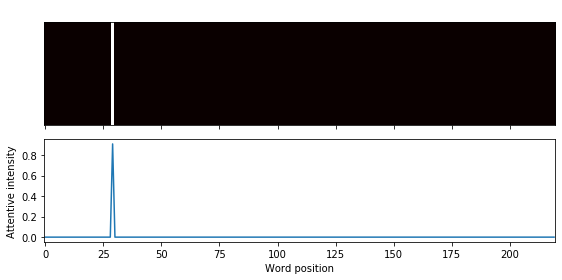

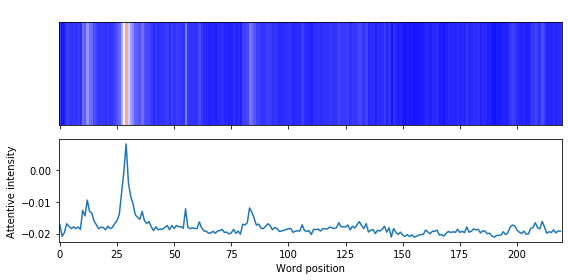

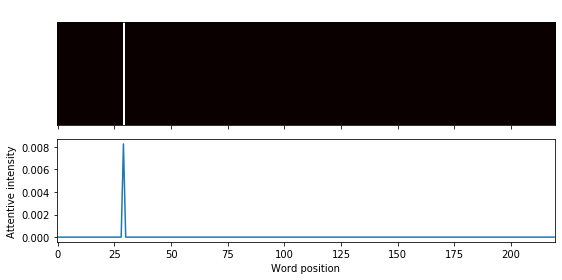

In [0]:
commt = xs[713]
tgs = ys[713]

see_results(commt, tgs, -2.3, 2.3, -0.023, 0.023)

definition of the word bigot is ? it ' s an intolerance for anyone ' s ideas that are not your own . you fit this to a t . i am not anti republican , or anti conservative . i ' ve been a card - carrying member of both major political parties , as well as voted for a number of third party candidates . i am not anti anything , except when someone is out there pointing their fingers and spewing bigoted assumptions as though they are facts . i don ' t make posts like " haha stupid inbred conservatives can ' t read that ' s why they elected trump ! " in fact i ' ve been quick to accept corrections and freely admit agreement . you ' re the one saying : " stupid snowflakes , liberalism is a mental disorder " any chance you get . i ' m just in the center and try to be pragmatic , that ' s why i sound extreme to you : you ' re on the fringe . you ' re keep trying to shove a square peg through a round hole because you think the world works in black and white " us vs them " ways . it doesn ' t .


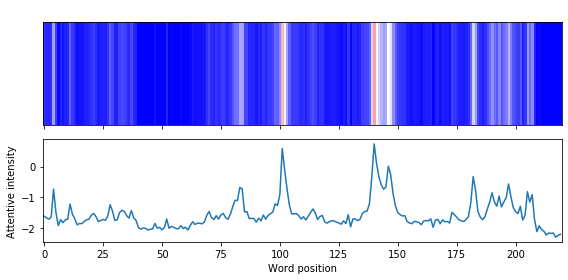

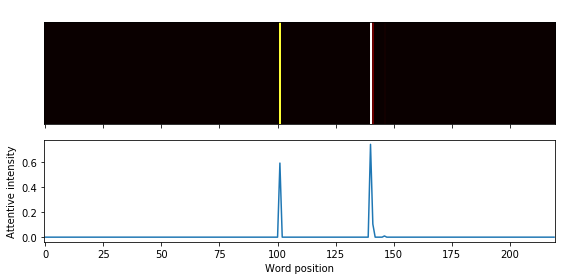

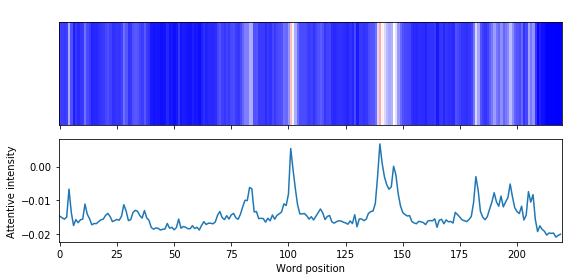

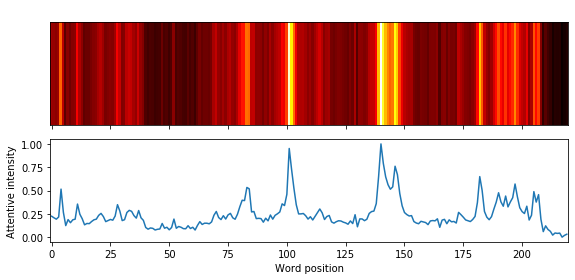

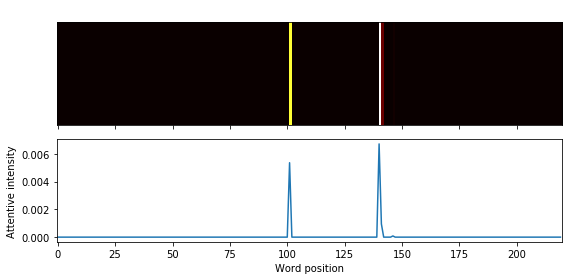

In [0]:
commt = xs[1019]
tgs = ys[1019]

see_results(commt, tgs, -2.0, 2.0, -0.02, 0.02)

In [0]:
# val samples
xs, ys = next(it)
xs, ys = xs.numpy(), ys.numpy()

In [0]:
np.where(ys[:,0]==1)[0]

array([403, 635])

one who said this , " looking at a young black woman in the group , i told her : ' i would rather be a black man in america than a black woman in africa . ' ” the black woman said nothing in reply , but there was an acknowledgment in her eyes that she had heard me . had she wanted to , i have no doubt that she was capable of responding on her own . ? " this is found documented in her article , " young facists colonize portland " she also uses her lack of class to say that there is still violence and " it ’ s home - grown , native - on - native . " also in the comments section of her article is this awesome comment by her about wanting to vote for trump to scare people - - - i mean guys how can this lady be racist ? ! hahahaha she is in denial about it though . i noticed this ladies name on articles before about this <unk> and googled her name . enjoy her crazy attempt to defend herself after this garbage . http : / / www . <unk> . com / 2016 / 03 / young - fascists - colonize - portlan

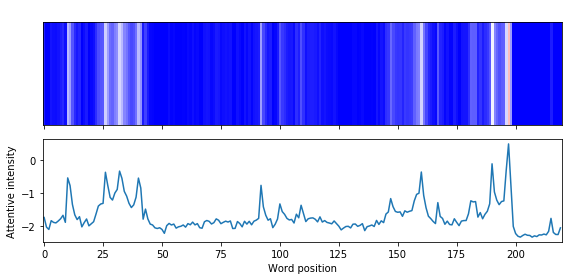

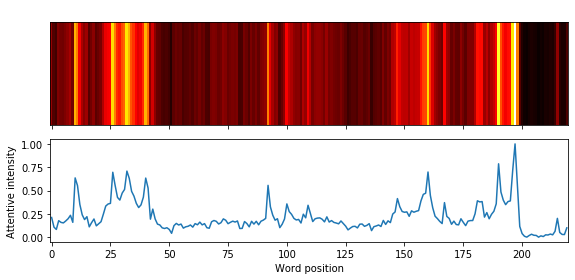

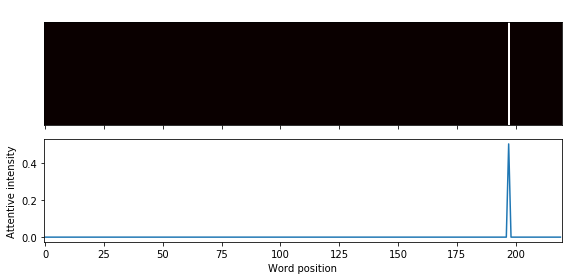

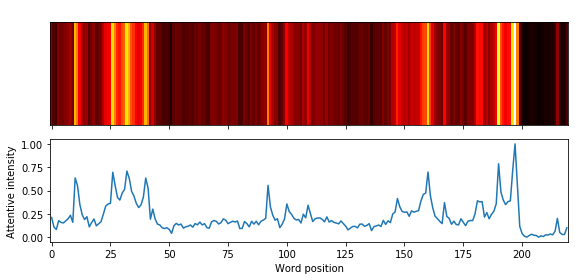

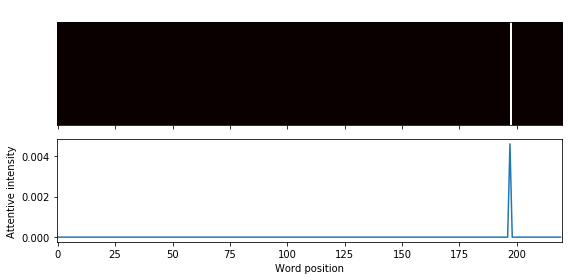

In [0]:
commt = xs[403]
tgs = ys[403]

see_results(commt, tgs, -2.0, 2.0, -0.02, 0.02)

pretty reasonable for this type of talk to emerge given what ' s just happened the last week . elway has never fooled around and goofed off when it came to football . he makes his decisions and he expects a player to give 100 % effort just like any gm does . it ' s obvious that lynch wasn ' t setting the world on fire like sloter did . it ' s all about mental toughness from your number 1 position . so far i don ' t think anyone can say that siemian isn ' t showing this toughness . we all saw it from sloter . we caught a few glimpses of it from osweiler in his first starts as a bronco . can ' t say that lynch has shown any signs yet , but to be fair he has pretty high expectations . sometimes players lose that mental edge and hard to get it back in focus . in my eyes lynch lost confidence when it wasn ' t happening and coming together for him . we ' ll see if <unk> can answer the bell if he gets called upon . i liked osweiler , but i knew that i didn ' t want elway to overpay . houston 

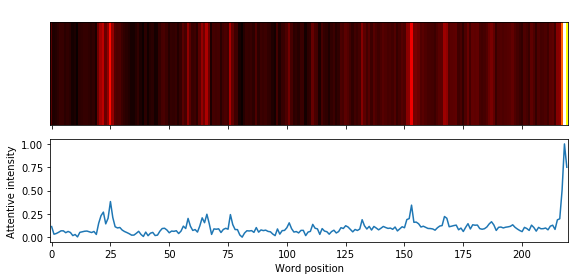

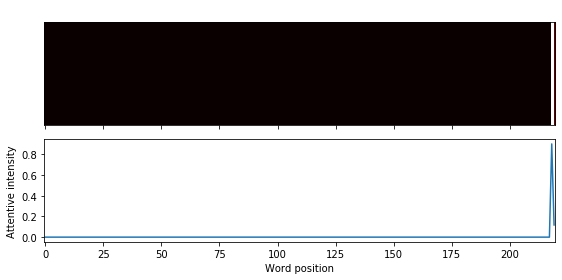

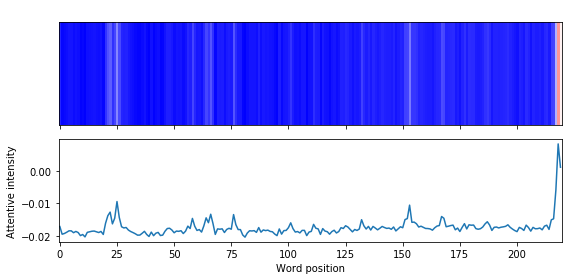

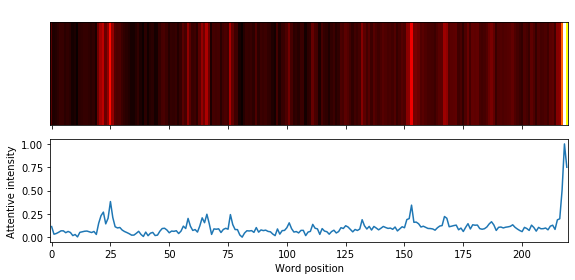

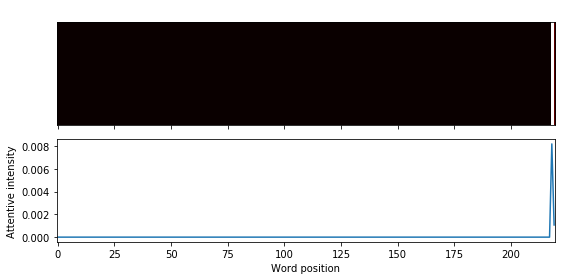

In [0]:
commt = xs[635]
tgs = ys[635]

see_results(commt, tgs, -2.0, 2.0, -0.02, 0.02)

In [0]:
np.where(ys[:,0]>=0.6)[0]

array([   6,   11,   55,  119,  127,  128,  133,  172,  174,  185,  200,
        208,  215,  229,  231,  240,  260,  320,  325,  403,  428,  471,
        507,  562,  595,  604,  620,  635,  676,  708,  724,  728,  748,
        778,  786,  787,  804,  839,  843,  903,  910,  924,  939,  944,
       1010])

don ' t care if they lose their money either . it couldn ' t happen to nicer people . but i am still allowed to express the opinion that they are being idiots falling for one of the most dangerous fallacies in economics and that this will come to bite them in the ass . in this regard i highly advise everybody to not invest in fossil fuel shares - it ' s a great way to lose your life savings very soon . now here ' s the <unk> - if we actually wanted to - we could have 100 % clean energy supply around the world in mmm , 5 years , it ' s a far smaller project than going to the moon in 10 and we pulled that off . it will cost a fraction of that - and this one is guaranteed to be a profitable excercise so in the end the actual cost is negative . and how convenient is it that , when we do that , the oil in existing locations will be able to supply our remaining needs for centuries to come - so no need to go ruin the arctic any further . by the time we run out , we won ' t be using it anymore

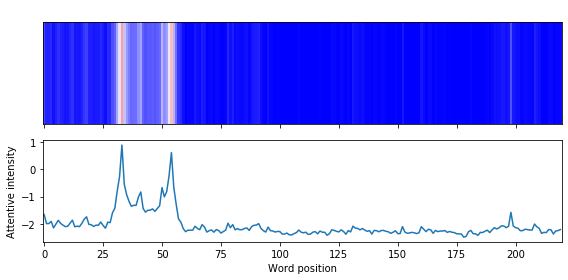

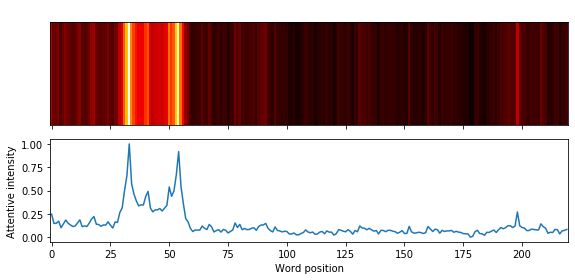

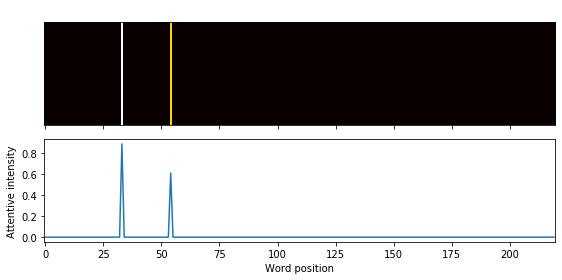

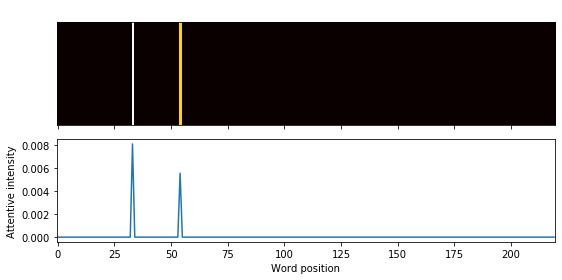

In [0]:
commt = xs[11]
tgs = ys[11]

see_results(commt, tgs, -2.3, 2.3, -0.023, 0.023)

“ if i had a gun , i ’ d shoot that nigger . ” , 3 . " . . . as ' nigger ' is . . . " ortal ' s comments : 1 . “ hey * * , ” [ sic ] yelled at him at an lcc parking lot , 2 . having the word * * [ sic ] scratched on his vehicle while at vrc . additional examples from lcc include : 1 . a sitting vp for instruction & student services , cheryl roberts , ( who parenthetically was not the # 1 candidate - an african american male ; nor the # 2 candidate - an asian american woman but the # 3 ranked candidate ) was routinely referred to by staff as the " . . . nigger barbie . . . " what happened to the # number one candidate , paul <unk> , was a topic of discussion at the time , e . g . " . . . they are taking out all the urinals in the 2nd floor ( of the administration building ) men ' s bathroom . " - tim craig . thus , the recently completed the myths surrounding a post - racial america ' s methodology might interest you .

with labels 0.6000000238418579
with prediction prob. [0.623142]

Wo

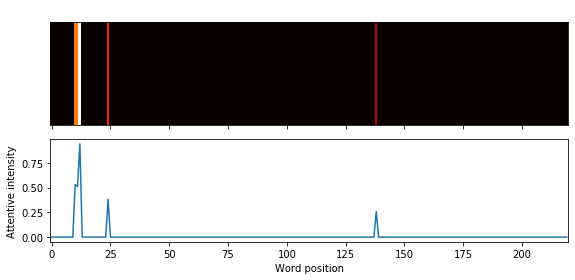

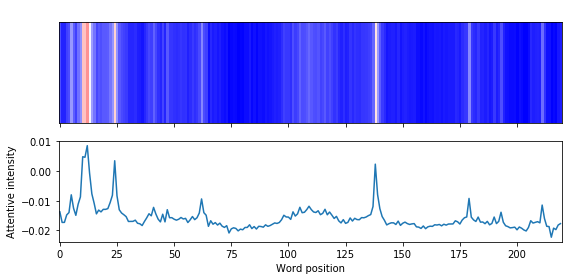

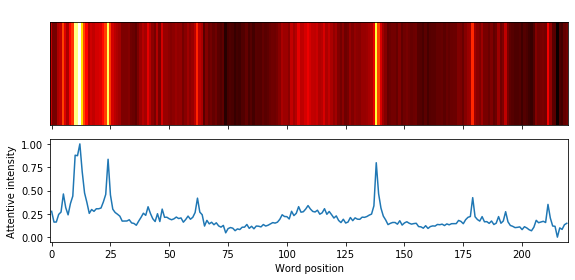

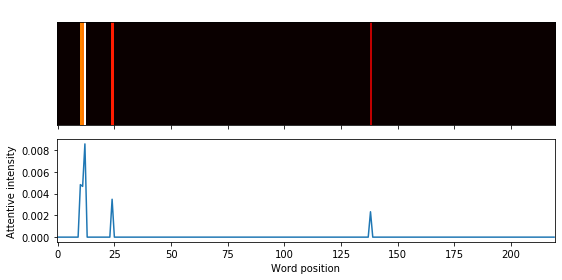

In [0]:
commt = xs[119]
tgs = ys[119]

see_results(commt, tgs, -2.0, 2.0, -0.02, 0.02)

' re being a jerk . it ' s perfectly valid for people to call you on it . where are you from anyway ? outside of los anchorage and surrounds , dumpster diving is practically an olympic sport among alaskans . if someone like you is dumb enough to throw something of value away , or something i can use to fix something , or make something else out of , your loss , my gain . old alaskan adage , " never toss anything that might have value . " of course you sound off like you ' ve lived a very soft and entitled life , and never spent time in the company of men with little tolerance for lip like yours , so i wouldn ' t expect you to understand this . i can ' t help but wonder what you are like when you don ' t have the internet separating you from better men than you telling you to shut your pie hole . seemed like a good and bright kid ( no one cares what you think little <unk> - just thought i ' d save you some time ) . shame this . i hope apd figures this out so his poor folks can have some

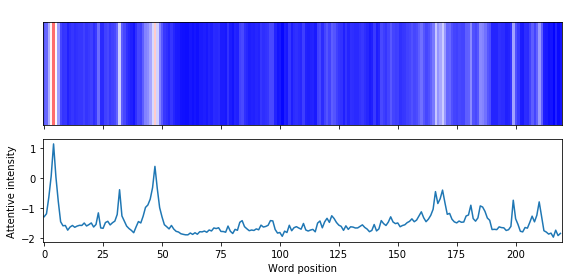

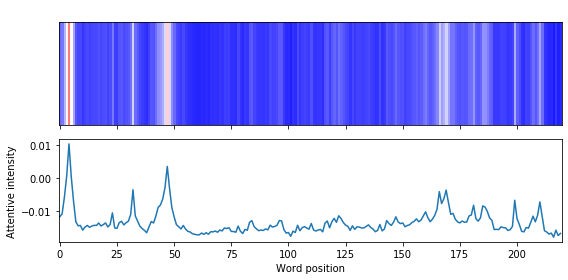

In [0]:
commt = xs[778]
tgs = ys[778]

see_results(commt, tgs, -2.0, 2.0, -0.02, 0.02)

thank you for this article , all i need to know not to vote for her . while i agree we could use some more diverse voices running for mayor and i even liked some of her background as a potential candidate ; what we don ' t need is someone who derisively lumps all middle aged white guys together . sorry but change that wording ( and from someone else ) to " another middle aged white woman " and the candidate would get hammered for sexism , ageism , etc . . . might have been a snarky comment for humor , and that is what i want for a mayor . . . someone snarky .

with labels 0.3
with prediction prob. [0.18140024]

Words focused by grad-CAM:




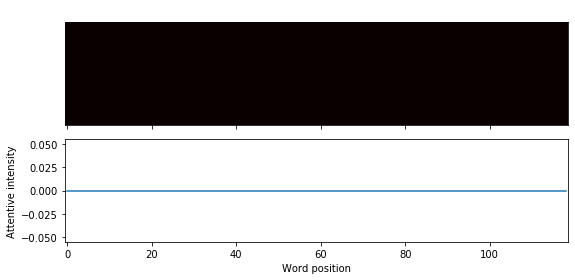

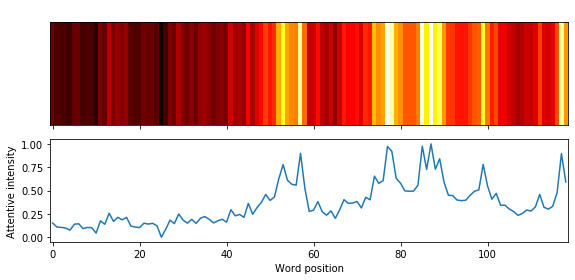

In [0]:
# labeled 0.300000, 1.000000, 1.000000, 0.0, 0.0, 0.0, 0.0, 0.00, 1.0, 0.0
sample_str = """
Thank you for this article, all I need to know not to vote for her.   While I agree we could use some more diverse voices running for mayor and I even liked some of her background as a potential candidate; what we don't need is someone who derisively lumps all middle aged white guys together.  
Sorry but change that wording (and from someone else) to "another middle aged white woman" and the candidate would get hammered for sexism, ageism, etc...  
Might have been a snarky comment for humor, and that is what i want for a mayor...someone snarky.
"""

commt = preprocessing(sample_str)
tgs = np.array([0.3])
see_results(commt[0], tgs, -3.0, 3.0, -0.05, 0.05)

this is a great story . man . i wonder if the person who yelled " shut the fuck up ! " at him ever heard it .

with labels 0.44
with prediction prob. [0.786153]

Words focused by grad-CAM:
shut the fuck up



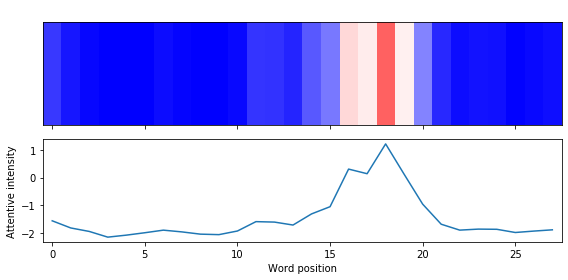

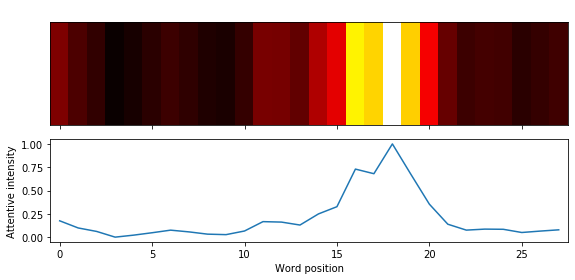

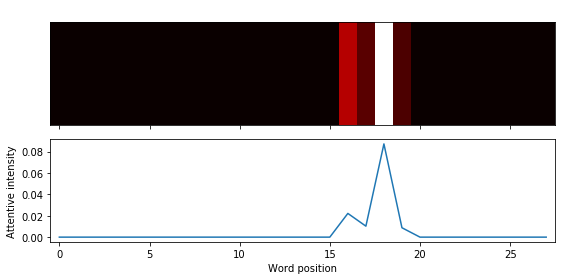

In [0]:
# labeled 0.440000, 0.600000, 0.000000, 0.0, 0.0, 0.0, 0.0, 0.00, 0.0, 0.0
sample_str = """
This is a great story. Man. I wonder if the person who yelled "shut the fuck up!" at him ever heard it.
"""

commt = preprocessing(sample_str)
tgs = np.array([0.44])
see_results(commt[0], tgs, -2.0, 2.0, -0.15, 0.15)

my thoughts are that people should stop being stupid and ignorant . climate change scientifically proven . it isn ' t a debate .

with labels 0.2
with prediction prob. [0.7896348]

Words focused by grad-CAM:
being stupid and ignorant



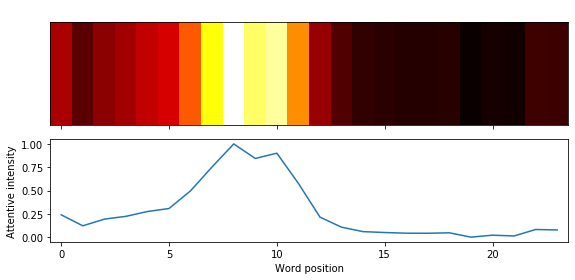

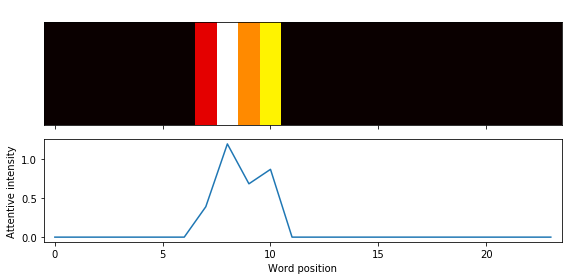

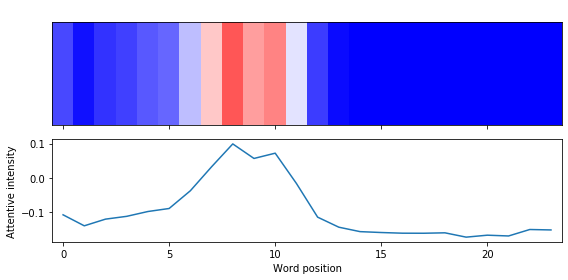

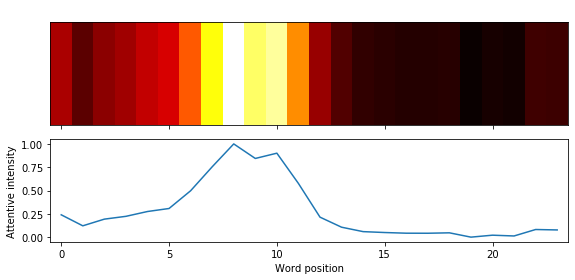

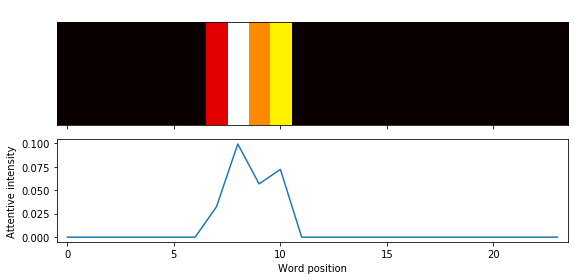

In [0]:
sample_str = """
My thoughts are that people should stop being stupid and ignorant. Climate change scientifically proven. It isn't a debate.
"""

commt = preprocessing(sample_str)
tgs = np.array([0.2])
see_results(commt[0], tgs, -2.0, 2.0, -0.15, 0.15)

my thoughts are that people should stop being ignorant . climate change scientifically proven . it isn ' t a debate .

with labels 0.0
with prediction prob. [0.5669176]

Words focused by grad-CAM:
ignorant



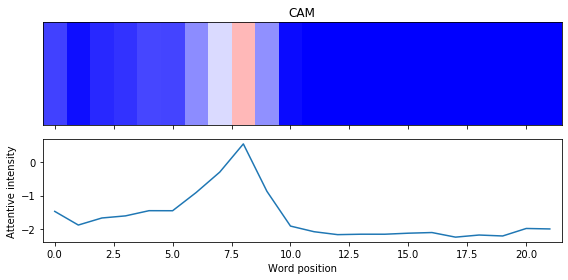

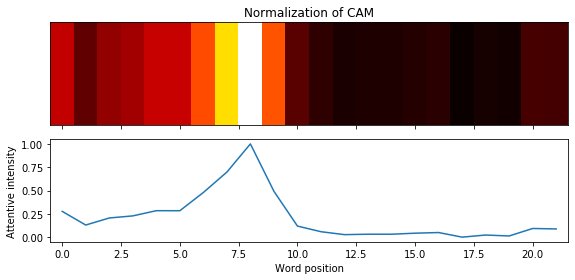

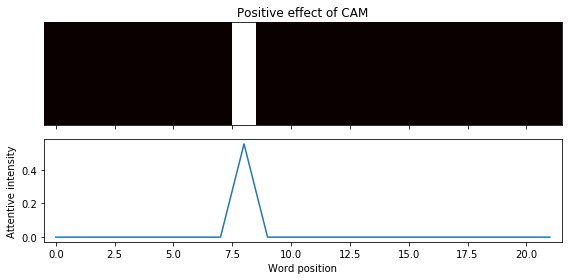

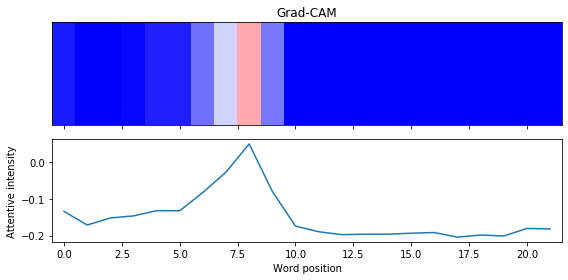

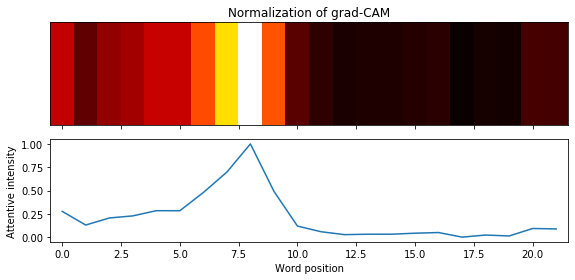

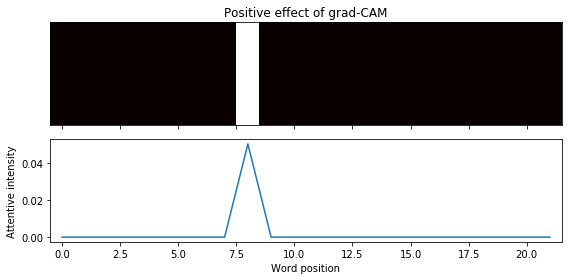

In [160]:
sample_str = """
My thoughts are that people should stop being ignorant. Climate change scientifically proven. It isn't a debate.
"""

commt = preprocessing(sample_str)
tgs = np.array([0.0])
see_results(commt[0], tgs, -2.0, 2.0, -0.15, 0.15)

i am a gay woman .

with labels 0.0
with prediction prob. [0.6219523]

Words focused by grad-CAM:
gay



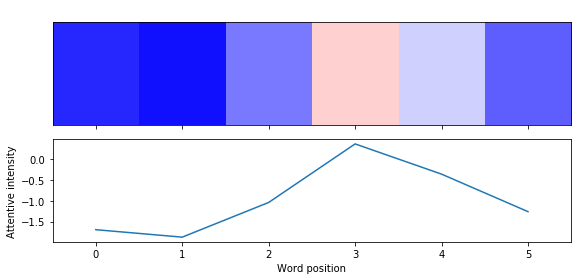

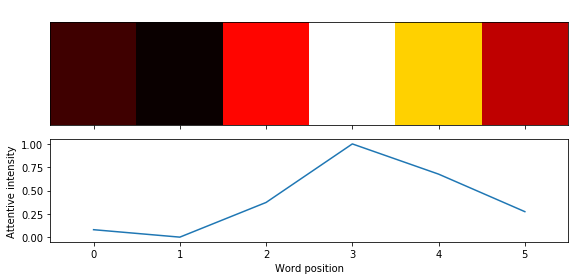

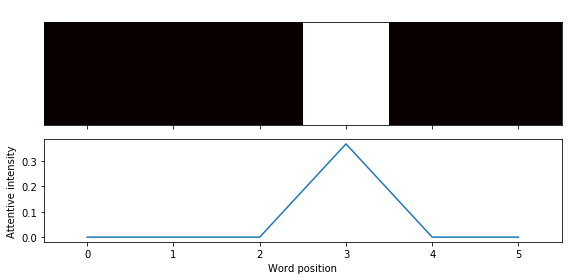

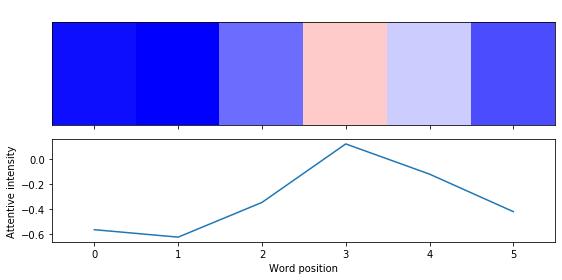

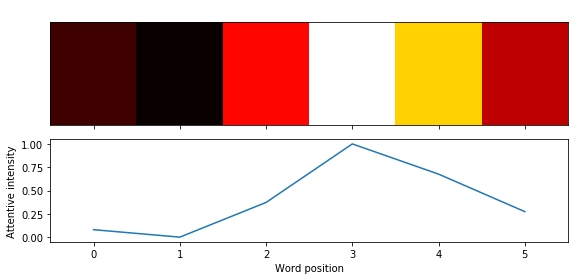

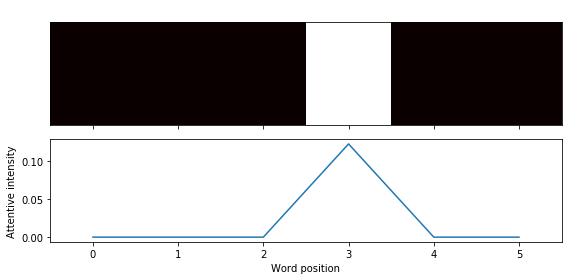

In [0]:
sample_str = """
I am a gay woman.
"""

commt = preprocessing(sample_str)
tgs = np.array([0.0])
see_results(commt[0], tgs, -2.0, 2.0, -0.6, 0.6)

no . you made it about race when you chose to act like some 0 . 3 % of murders are different from the other 99 . 6 % , more worthy of protest , and there was absolutely nothing else different about those 0 . 3 % . only seriously extreme racists ever use the term ' race card ' . complaining about the race card is proof of being a racist . non racists don ' t have any fear of discussing the influence of race on any topic . and only the really dumbest of the dumb use the word ' libtard ' . note how i discussed the issue in terms of numbers , facts , empirical reality untimely by emotion or group loyalty . i didn ' t ' bring race into it ' , i mathematically proved it could be about nothing else . and what could you offer in return ? any rational thoughts ? improved numbers ? a flaw in my calculation ? nope . all you have is a silly attempt at a personal insult . so i ' ve won this debate by all measures . just hush now . you ' re embarrassing yourself .

with labels 1.0
with prediction pr

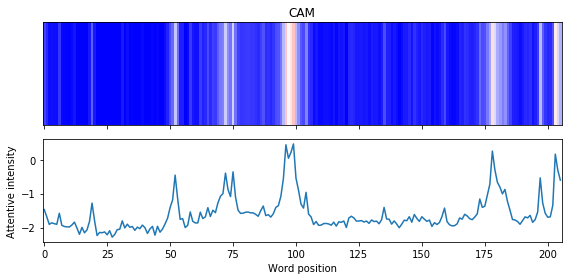

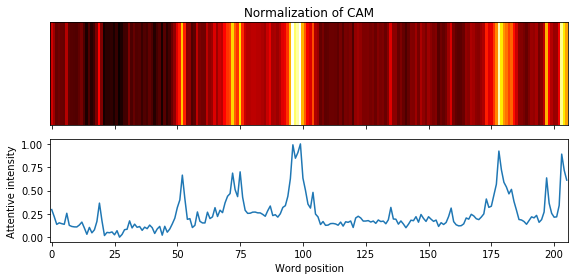

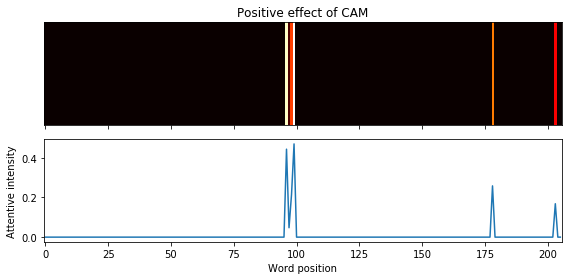

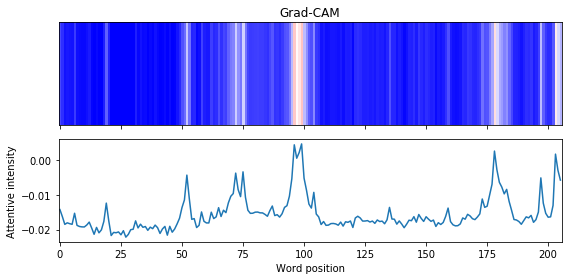

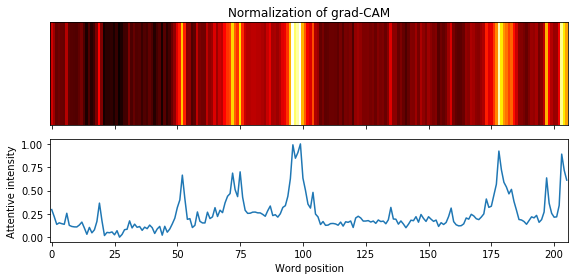

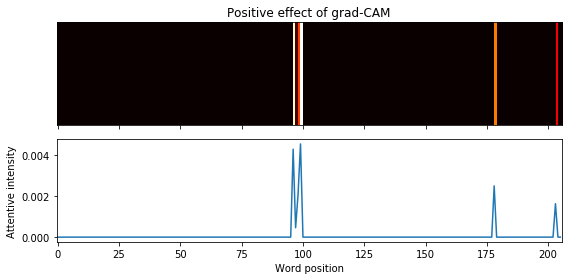

In [0]:
sample_str = """
No. You made it about race when you chose to act like some 0.3% of murders are different from the other 99.6 %, more worthy of protest, and there was absolutely nothing else different about those 0.3%. Only seriously extreme racists ever use the term 'race card'. Complaining about the race card is proof of being a racist. Non racists don't have any fear of discussing the influence of race on any topic. And only the really dumbest of the dumb use the word 'libtard'. Note how I discussed the issue in terms of numbers, facts, empirical reality untimely by emotion or group loyalty. i didn't 'bring race into it', I mathematically proved it could be about nothing else. And what could you offer in return? Any rational thoughts? Improved numbers? A flaw in my calculation? Nope. All you have is a silly attempt at a personal insult. So I've won this debate by all measures. Just hush now. You're embarrassing yourself.
"""

commt = preprocessing(sample_str)
tgs = np.array([1.0])
see_results(commt[0], tgs, -2.0, 2.0, -0.02, 0.02)

### Using lime and eli5

In [0]:
!pip install lime
!pip install eli5

In [0]:
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

import eli5
from eli5.lime import TextExplainer

In [0]:
def predict_pipeline(raw_strings):
    """
    Input: list of d strings 
    Return: numpy array of shape (d, 2)
    """
    comments = [preprocessing(s) for s in raw_strings]
    ps = [get_preds(l_dtype(c), model, 0).item() for c in comments]
    return np.array([[1-p, p] for p in ps])

In [0]:
explainer = LimeTextExplainer(class_names=['non-toxic', 'toxic'])
te = TextExplainer(random_state=SEED)

In [0]:
%%time
sample_str = """
This is a great story. Man. I wonder if the person who yelled "shut the fuck up!" at him ever heard it.
"""

exp = explainer.explain_instance(sample_str, predict_pipeline, num_features=6)

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


CPU times: user 12.9 s, sys: 1.33 s, total: 14.2 s
Wall time: 13.4 s


In [0]:
get_preds(l_dtype(preprocessing(sample_str)), model, 0).item()

0.7861530184745789

In [0]:
exp.show_in_notebook(text=True)

In [0]:
te.fit(sample_str, predict_pipeline)
te.show_prediction(target_names=['non-toxic', 'toxic'])

In [0]:
sample_str = """
My thoughts are that people should stop being stupid and ignorant. Climate change scientifically proven. It isn't a debate.
"""

exp = explainer.explain_instance(sample_str, predict_pipeline, num_features=6)

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


In [0]:
get_preds(l_dtype(preprocessing(sample_str)), model, 0).item()

0.7896348237991333

In [0]:
exp.show_in_notebook(text=True)

In [0]:
te.fit(sample_str, predict_pipeline)
te.show_prediction(target_names=['non-toxic', 'toxic'])

In [161]:
sample_str = """
My thoughts are that people should stop being ignorant. Climate change scientifically proven. It isn't a debate.
"""

exp = explainer.explain_instance(sample_str, predict_pipeline, num_features=6)

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


In [162]:
get_preds(l_dtype(preprocessing(sample_str)), model, 0).item()

0.5669175982475281

In [163]:
exp.show_in_notebook(text=True)

In [164]:
te.fit(sample_str, predict_pipeline)
te.show_prediction(target_names=['non-toxic', 'toxic'])

In [0]:
sample_str = """
I am a gay woman.
"""

exp = explainer.explain_instance(sample_str, predict_pipeline, num_features=6)

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


In [0]:
get_preds(l_dtype(preprocessing(sample_str)), model, 0).item()

0.6219522953033447

In [0]:
exp.show_in_notebook(text=True)

In [0]:
te.fit(sample_str, predict_pipeline)
te.show_prediction(target_names=['non-toxic', 'toxic'])

In [0]:
sample_str = """
No. You made it about race when you chose to act like some 0.3% of murders are different from the other 99.6 %, more worthy of protest, and there was absolutely nothing else different about those 0.3%. Only seriously extreme racists ever use the term 'race card'. Complaining about the race card is proof of being a racist. Non racists don't have any fear of discussing the influence of race on any topic. And only the really dumbest of the dumb use the word 'libtard'. Note how I discussed the issue in terms of numbers, facts, empirical reality untimely by emotion or group loyalty. i didn't 'bring race into it', I mathematically proved it could be about nothing else. And what could you offer in return? Any rational thoughts? Improved numbers? A flaw in my calculation? Nope. All you have is a silly attempt at a personal insult. So I've won this debate by all measures. Just hush now. You're embarrassing yourself.
"""

exp = explainer.explain_instance(sample_str, predict_pipeline, num_features=6)

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


In [0]:
get_preds(l_dtype(preprocessing(sample_str)), model, 0).item()

0.5987732410430908

In [0]:
exp.show_in_notebook(text=True)

In [0]:
te.fit(sample_str, predict_pipeline)
te.show_prediction(target_names=['non-toxic', 'toxic'])